In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime

# Crypto Trend Following

testing trend following on crypto (start with bitcoin).

Methods to test:
- Time Series Momentum
- Breakouts
- Moving Average Cross Over

Also try to optimize the best parameters

FUTURE WORK
- implement same models with week day data only (if to use Avanza or futures)

In [2]:
## Data import of WE

dat_tmp = yf.download('BTC-USD')

[*********************100%***********************]  1 of 1 completed


In [3]:
close = pd.DataFrame(dat_tmp['Close'])

### Time Series Momentum

In [4]:
def time_series_TF(data , lookback, perf = 'Yes'):
    df = close.copy()
    df['ret'] = df['Close'].pct_change().shift(-1)
    df['TSM'] = df['Close'].pct_change(lookback)
    df['Signal'] = np.where(df['TSM']>0, 1, 0)
    df = df.dropna()
    df.loc[:,'Strategy_ret'] = (df['ret']* df['Signal']).values
    df.loc[:,'Bench'] = ((df['ret']+1).cumprod()).values
    df.loc[:,'Strategy_cum'] = ((df['Strategy_ret']+1).cumprod()).values
    
    #metrics
    vol = round(df['Strategy_ret'].std()* 252 ** 0.5,3)
    mean_ret = df['Strategy_ret'].mean()*252
    sharpe = mean_ret/vol
    
    return sharpe
    

In [5]:
test = pd.DataFrame(range(1,101))
test.columns = ['lookback']
test.loc[:,'Sharpe'] = None

In [6]:
for i in range(len(test)):
    
    test.loc[i, 'Sharpe'] = time_series_TF(close ,test.loc[i, 'lookback'] , perf = 'Yes')

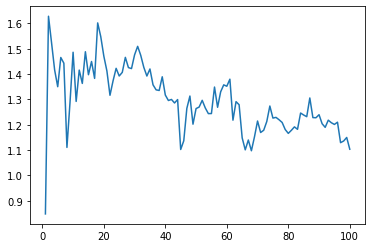

In [7]:
plt.plot(test['lookback'], test['Sharpe']);

### Breakouts

In [8]:
def break_out(data , lookback_low, lookback_high, perf = 'Yes'):
    
    brk_df = data.copy()
    brk_df.loc[:, 'low'] = brk_df['Close'].shift(1).rolling(lookback_low).min()
    brk_df.loc[:, 'high'] = brk_df['Close'].shift(1).rolling(lookback_high).max()

    #entry signal
    brk_df.loc[:, 'entry'] = brk_df.Close > brk_df.high
    brk_df.loc[:, 'exit'] = brk_df.Close < brk_df.low

    #signal generation
    brk_df['signal'] = np.nan 
    brk_df.loc[brk_df.entry,'signal']= 1 
    brk_df.loc[brk_df.exit,'signal']= 0 
    brk_df['signal'] = brk_df['signal'].fillna(method='ffill')

    #calc return
    brk_df['ret'] = brk_df['Close'].pct_change().shift(-1)
    brk_df.loc[:,'Strategy_ret'] = (brk_df['ret']* brk_df['signal']).values
    brk_df.loc[:,'Bench'] = ((brk_df['ret']+1).cumprod()).values
    brk_df.loc[:,'Strategy_cum'] = ((brk_df['Strategy_ret']+1).cumprod()).values
    brk_df = brk_df.dropna()

    vol = round(brk_df['Strategy_ret'].std()* 252 ** 0.5,3)
    mean_ret = brk_df['Strategy_ret'].mean()*252
    sharpe = mean_ret/vol
    
    return(sharpe)

In [9]:
brk_eval = pd.DataFrame(columns=range(0,100, 5), index=range(0, 100, 5))

In [10]:
for i in brk_eval.index[1:]:
    
    for j in brk_eval.columns[1:]:
        
          brk_eval.loc[i,j] = break_out(close , lookback_low = i, lookback_high = j, perf = 'Yes')
        
brk_eval = brk_eval.drop(0, axis=1).drop(0, axis=0)

In [12]:
brk_eval

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
5,1.36972,1.42204,1.539,1.60363,1.60158,1.56804,1.54089,1.53068,1.45858,1.40618,1.30727,1.29726,1.31061,1.32697,1.34898,1.38233,1.37719,1.36977,1.34978
10,1.08781,1.20032,1.26444,1.38048,1.39024,1.42028,1.39354,1.3853,1.32572,1.26493,1.17393,1.17092,1.19058,1.24127,1.23786,1.25993,1.25423,1.24759,1.21867
15,1.25105,1.32171,1.33644,1.48843,1.49884,1.48479,1.48123,1.47576,1.42208,1.36912,1.28115,1.29993,1.33777,1.35853,1.35618,1.33574,1.30656,1.30076,1.27461
20,1.28283,1.30082,1.35131,1.44777,1.46571,1.46967,1.48282,1.45753,1.39401,1.35048,1.27026,1.28817,1.32708,1.35671,1.35461,1.33535,1.30782,1.29907,1.27449
25,1.16273,1.23521,1.24558,1.22278,1.22253,1.22235,1.24083,1.24528,1.18497,1.13606,1.05701,1.07509,1.14083,1.16412,1.16142,1.141,1.11321,1.10788,1.08379
30,1.18592,1.26805,1.28344,1.24794,1.2705,1.25235,1.29845,1.30384,1.24273,1.20197,1.12352,1.15054,1.21254,1.24165,1.23694,1.21559,1.18754,1.17979,1.15696
35,1.1616,1.2676,1.22735,1.19862,1.19158,1.18866,1.25805,1.27171,1.21707,1.19759,1.14057,1.18055,1.24379,1.27545,1.27385,1.25337,1.22298,1.21638,1.19442
40,1.16003,1.22657,1.18578,1.13732,1.12933,1.12553,1.19353,1.20964,1.15509,1.14644,1.08944,1.12894,1.19142,1.2224,1.22057,1.19973,1.16929,1.16493,1.14022
45,1.15903,1.22324,1.19154,1.16382,1.16745,1.16038,1.17878,1.22932,1.17944,1.19427,1.14065,1.19029,1.27216,1.30518,1.30097,1.28182,1.2532,1.24649,1.22549
50,1.13582,1.22874,1.18046,1.16427,1.1194,1.13378,1.15145,1.21661,1.17064,1.18532,1.13328,1.1927,1.27222,1.31184,1.30777,1.2893,1.2643,1.25779,1.23752


## Moving Average Cross Over

In [16]:
def cross_over(data , lookback_slow, lookback_fast, perf = 'Yes'):
    cross_df = data.copy()
    cross_df.loc[:, 'slow']= cross_df['Close'].shift(1).ewm(span=lookback_slow).mean()
    cross_df.loc[:, 'fast']= cross_df['Close'].shift(1).ewm(span=lookback_fast).mean()

    cross_df.loc[:, 'entry'] = cross_df.fast > cross_df.slow
    cross_df.loc[:, 'exit'] = cross_df.fast < cross_df.slow

    cross_df['signal'] = np.nan 
    cross_df.loc[cross_df.entry,'signal']= 1 
    cross_df.loc[cross_df.exit,'signal']= 0 
    cross_df['signal'] = cross_df['signal'].fillna(method='ffill')

    #calc return
    cross_df['ret'] = cross_df['Close'].pct_change().shift(-1)
    cross_df.loc[:,'Strategy_ret'] = (cross_df['ret']* cross_df['signal']).values
    cross_df.loc[:,'Bench'] = ((cross_df['ret']+1).cumprod()).values
    cross_df.loc[:,'Strategy_cum'] = ((cross_df['Strategy_ret']+1).cumprod()).values
    cross_df = cross_df.dropna()
    
    vol = round(cross_df['Strategy_ret'].std()* 252 ** 0.5,3)
    mean_ret = cross_df['Strategy_ret'].mean()*252
    sharpe = mean_ret/vol
    
    return(sharpe)



In [17]:
cross_eval = pd.DataFrame(columns=range(0,100, 5), index=range(0, 100, 5))

In [18]:
for i in cross_eval.index[1:]:
    
    for j in test.columns[1:]:
        cross_eval.loc[i ,j ] = cross_over(close , lookback_slow = i, lookback_fast = j, perf = 'Yes')
        
cross_eval = cross_eval.drop(0, axis=1).drop(0, axis=0)

TypeError: '<' not supported between instances of 'str' and 'int'

In [121]:
cross_eval

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
5,NaN,0.364025,0.23686,0.196116,0.116202,0.189643,0.198323,0.139525,0.190555,0.220011,0.247693,0.192085,0.193249,0.138559,0.150004,0.145303,0.0869816,0.133422,0.178168
10,NaN,NaN,0.0956694,0.202622,0.23934,0.252487,0.218883,0.226425,0.241081,0.284477,0.201803,0.149615,0.110142,0.229597,0.265755,0.189091,0.141433,0.118344,0.111142
15,NaN,1.43883,NaN,0.171966,0.220499,0.224895,0.247789,0.278478,0.252035,0.109632,0.162924,0.107117,0.0995939,0.0966079,0.104049,0.115568,0.130993,0.147788,0.20704
20,NaN,1.3298,1.33582,NaN,0.236716,0.333402,0.292819,0.151079,0.155101,0.131865,0.0881053,0.0488206,0.0842573,0.0862271,0.126205,0.114957,0.193783,0.261023,0.292785
25,NaN,1.27929,1.29175,1.27317,NaN,0.206388,0.0898265,0.169313,0.0554322,0.0158306,0.0802086,0.0850506,0.231275,0.208968,0.32675,0.262041,0.170709,0.200455,0.263743
30,NaN,1.26514,1.28321,1.17801,1.2862,NaN,0.158245,0.0574776,0.0479843,0.0665169,0.202889,0.210678,0.215058,0.258084,0.161703,0.163728,0.251231,0.222016,0.219999
35,NaN,1.29088,1.25464,1.20941,1.3658,1.29707,NaN,0.0583534,0.18195,0.236346,0.206579,0.262095,0.187425,0.131528,0.191932,0.220231,0.273466,0.267766,0.239903
40,NaN,1.28006,1.22378,1.32443,1.29076,1.36835,1.36486,NaN,0.204245,0.21502,0.238298,0.133228,0.157922,0.210516,0.271554,0.295038,0.257725,0.224353,0.282735
45,NaN,1.25884,1.23828,1.30231,1.36985,1.37313,1.23852,1.21658,NaN,0.231484,0.115376,0.189721,0.243232,0.272086,0.272188,0.230811,0.260465,0.244478,0.240314
50,NaN,1.21523,1.35195,1.32121,1.39844,1.35855,1.19541,1.20534,1.19411,NaN,0.191241,0.226667,0.259866,0.267147,0.245589,0.254421,0.241737,0.193119,0.302201


In [23]:
brk_df = close.copy()
brk_df.loc[:, 'low'] = brk_df['Close'].shift(1).rolling(20).min()
brk_df.loc[:, 'high'] = brk_df['Close'].shift(1).rolling(40).max()

#entry signal
brk_df.loc[:, 'entry'] = brk_df.Close > brk_df.high
brk_df.loc[:, 'exit'] = brk_df.Close < brk_df.low

#signal generation
brk_df['signal'] = np.nan 
brk_df.loc[brk_df.entry,'signal']= 1 
brk_df.loc[brk_df.exit,'signal']= 0 
brk_df['signal'] = brk_df['signal'].fillna(method='ffill')

#calc return
brk_df['ret'] = brk_df['Close'].pct_change().shift(-1)
brk_df.loc[:,'Strategy_ret'] = (brk_df['ret']* brk_df['signal']).values
brk_df.loc[:,'Bench'] = ((brk_df['ret']+1).cumprod()).values
brk_df.loc[:,'Strategy_cum'] = ((brk_df['Strategy_ret']+1).cumprod()).values
brk_df = brk_df.dropna()

vol = round(brk_df['Strategy_ret'].std()* 252 ** 0.5,3)
mean_ret = brk_df['Strategy_ret'].mean()*252
sharpe = mean_ret/vol

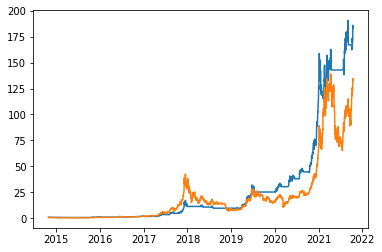

In [24]:
plt.plot(brk_df['Strategy_cum']);
plt.plot(brk_df['Bench'])

In [25]:
vol

0.413

In [26]:
round(brk_df['ret'].std()* 252 ** 0.5,3)

0.622